# Analysis, Model training, Predictions

## 1. Prepare the dataset
- load data
- create additional features by joining key and scale
- change data type of categorical features & encode labels


In [ ]:
from google.colab import drive
import os, sys
drive.mount('/content/drive')
os.chdir("path")
path = 'path'
os.listdir(path)

In [ ]:
#load data - for example the Grand Final Dataset
import pandas as pd
df = pd.read_csv('Eurovision_Grand_Final_Data_2008_2024.csv')
df = df.drop(['Unnamed: 0'], axis=1)
print(df.shape)

#create key+scale features
df['chords_key_scale'] = df['chords_key'] + "_" + df['chords_scale']
df['edma_key_scale'] = df['key_edma_key'] + "_" + df['key_edma_scale']
df['krumhansl_key_scale'] = df['key_krumhansl_key'] + "_" + df['key_krumhansl_scale']
df['temperley_key_scale'] = df['key_temperley_key'] + "_" + df['key_temperley_scale']


# Convert to categorical data type
df['chords_key'] = df['chords_key'].astype('category')
df['chords_scale'] = df['chords_scale'].astype('category')
df['chords_key_scale'] = df['chords_key_scale'].astype('category')

df['key_edma_key'] = df['key_edma_key'].astype('category')
df['key_edma_scale'] = df['key_edma_scale'].astype('category')
df['edma_key_scale'] = df['edma_key_scale'].astype('category')

df['key_krumhansl_key'] = df['key_krumhansl_key'].astype('category')
df['key_krumhansl_scale'] = df['key_krumhansl_scale'].astype('category')
df['krumhansl_key_scale'] = df['krumhansl_key_scale'].astype('category')

df['key_temperley_key'] = df['key_temperley_key'].astype('category')
df['key_temperley_scale'] = df['key_temperley_scale'].astype('category')
df['temperley_key_scale'] = df['temperley_key_scale'].astype('category')

df['to_country'] = df['to_country'].astype('category')
df['lyrics_english'] = df['lyrics_english'].astype('category')
df['lyrics_english_mix'] = df['lyrics_english_mix'].astype('category')

#label encoder for categorical features
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()  # 'winner', 'top3'
cols = ['to_country','chords_key', 'chords_scale', 'chords_key_scale', 'key_edma_key', 'key_edma_scale',
        'edma_key_scale', 'key_krumhansl_key', 'key_krumhansl_scale', 'krumhansl_key_scale', 'key_temperley_key',
        'key_temperley_scale', 'temperley_key_scale', 'lyrics_english','lyrics_english_mix']

for col in cols:
    df[col] = le.fit_transform(df[col])



#preview data
df.head()

(411, 105)


,idx,year,LY_SF_reciprocation,LY_SF_vote,LY_final_reciprocation,LY_final_vote,to_country,performer,song,place_contest,...,spectral_strongpeak,zerocrossingrate,label_1_to_3,label_1_to_5,label_1_to_10,place_contest_scaled,chords_key_scale,edma_key_scale,krumhansl_key_scale,temperley_key_scale
0,0,2008,0.0,0.000000,1.0,0.878049,36,Dima Bilan,Believe,1,...,1.244766,0.084002,1,1,1,0.000000,6,16,16,16
1,1,2008,0.0,0.000000,1.0,0.975610,44,Ani Lorak,Shady Lady,2,...,1.191915,0.083138,1,1,1,0.041667,19,19,19,19
2,2,2008,0.0,0.000000,0.8,0.609756,18,Kalomira,Secret Combination,3,...,0.785189,0.083331,1,1,1,0.083333,21,21,21,21
3,3,2008,0.0,0.000000,0.8,0.439024,1,Sirusho,"Qele, Qele",4,...,1.318361,0.065026,0,1,1,0.125000,1,1,1,1
4,4,2008,0.5,0.365854,0.0,0.000000,32,Maria,Hold On Be Strong,5,...,1.541387,0.060480,0,1,1,0.166667,9,9,9,9


In [ ]:
#df.info(verbose=True)

----------------------------------------
Split dataset into training and testing.

**Select year for testing!** for example, 2018

In [ ]:
train_data = df[df['year'] != 2018].reset_index(drop=True)
test_data = df[df['year'] == 2018].reset_index(drop=True)

## 2. Dimensionality Reduction for audio features

Principal Component Analysis is implemented, number of components determined with requirement of 95% of variance explained.
PCA transformed features replace the original subsets in the dataset.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca_and_integrate(df_train, df_test, feature_subsets, subset_names):

    def determine_pca_components(data, features):
        """Determine the number of PCA components for 95% variance explained."""
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data[features])
        pca = PCA()
        pca.fit(scaled_data)
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components = np.argmax(cumulative_variance >= 0.95) + 1
        print(num_components)
        return num_components, scaler, pca

    for subset, name in zip(feature_subsets, subset_names):
        # Determine number of components for training data
        num_components, scaler, pca = determine_pca_components(df_train, subset)

        # Apply PCA to training data
        train_scaled = scaler.transform(df_train[subset])
        train_pca = PCA(n_components=num_components).fit_transform(train_scaled)
        train_pca_columns = [f'{name}_PC{j+1}' for j in range(num_components)]
        train_pca_df = pd.DataFrame(train_pca, columns=train_pca_columns, index=df_train.index)

        # Apply PCA to testing data
        test_scaled = scaler.transform(df_test[subset])
        test_pca = PCA(n_components=num_components).fit_transform(test_scaled)
        test_pca_columns = [f'{name}_PC{j+1}' for j in range(num_components)]
        test_pca_df = pd.DataFrame(test_pca, columns=test_pca_columns, index=df_test.index)

        # Remove original features and add PCA components
        df_train = df_train.drop(columns=subset).join(train_pca_df)
        df_test = df_test.drop(columns=subset).join(test_pca_df)

    return df_train, df_test


feature_subsets = [
     ['barkbands_crest', 'barkbands_flatness_db', 'barkbands_kurtosis',
      'barkbands_skewness', 'barkbands_spread'],  # Barkbands
     ['erbbands_crest', 'erbbands_flatness_db', 'erbbands_kurtosis',
      'erbbands_skewness', 'erbbands_spread'],  # Erbbands
     ['melbands_crest', 'melbands_flatness_db', 'melbands_kurtosis',
      'melbands_skewness', 'melbands_spread'],  # Melbands 3
     ['spectral_centroid','spectral_complexity','spectral_decrease','spectral_energy',
      'spectral_energyband_high','spectral_energyband_low','spectral_energyband_middle_high',
      'spectral_energyband_middle_low','spectral_entropy','spectral_flux','spectral_kurtosis',
      'spectral_rms','spectral_rolloff','spectral_skewness','spectral_spread','spectral_strongpeak']  # Spectral
 ]

subset_names = ['barkbands', 'erbbands', 'melbands', 'spectral']

df_train, df_test = apply_pca_and_integrate(train_data, test_data, feature_subsets, subset_names)
print(df_train.shape)
print(df_test.shape)

4
4
3
7
(385, 96)
(26, 96)


## 3. Correlation Analysis


In [ ]:
fs_audio_lyrics = df[['barkbands_PC1', 'barkbands_PC2', 'barkbands_PC3', 'barkbands_PC4', 'erbbands_PC1','erbbands_PC2','erbbands_PC3','erbbands_PC4',
                            'melbands_PC1', 'melbands_PC2','melbands_PC3', 'spectral_PC1','spectral_PC2','spectral_PC3','spectral_PC4',
                            'spectral_PC5', 'spectral_PC6', 'spectral_PC7', 'chords_key_scale', 'edma_key_scale', 'krumhansl_key_scale', 'temperley_key_scale',
                            'length(s)', 'bpm', 'beats_count', 'beats_loudness', 'danceability', 'onset_rate', 'chords_changes_rate', 'chords_number_rate',
                            'chords_strength', 'hpcp_crest', 'hpcp_entropy', 'tuning_diatonic_strength', 'tuning_equal_tempered_deviation', 'tuning_frequency',
                            'tuning_nontempered_energy_ratio', 'chords_key', 'chords_scale', 'key_edma_strength', 'key_edma_key', 'key_edma_scale', 'key_krumhansl_strength',
                            'key_krumhansl_key', 'key_krumhansl_scale', 'key_temperley_strength', 'key_temperley_key', 'key_temperley_scale', 'average_loudness', 'dissonance',
                            'dynamic_complexity', 'hfc', 'loudness_ebu128_int', 'loudness_ebu128_range', 'pitch_salience', 'zerocrossingrate',
                            'n_gram_repetitiveness', 'compression_size_reduction', 'type_token_ratio', 'lyrics_english', 'lyrics_english_mix']]

fs_other = df[['to_country', 'LY_SF_reciprocation', 'LY_SF_vote', 'LY_final_reciprocation','LY_final_vote', 'running_final','yt_views_per_day']]

fs_y = df['place_contest_scaled']
fs_youtube = df['yt_views_per_day']


In [ ]:
from scipy.stats import spearmanr
import pandas as pd

def calculate_spearman_correlation(X, y):
    # Calculate Spearman correlation for each feature
    correlations = []
    for col in X.columns:
        corr, _ = spearmanr(X[col], y)
        correlations.append((col, corr))

    # Create a DataFrame with results
    corr_df = pd.DataFrame(correlations, columns=['Feature', 'Spearman Correlation'])

    # Sort by absolute correlation
    corr_df['Absolute Correlation'] = corr_df['Spearman Correlation'].abs()
    corr_df = corr_df.sort_values(by='Absolute Correlation', ascending=False)

    # Round Spearman Correlation values to 2 decimal places
    corr_df['Spearman Correlation'] = corr_df['Spearman Correlation'].round(2)

    # Print the sorted DataFrame
    print("Spearman Correlation Scores:")
    print(corr_df[['Feature', 'Spearman Correlation']])

    return corr_df[['Feature', 'Spearman Correlation']]

# Example usage
sorted_spearman = calculate_spearman_correlation(fs_other, fs_y)


Spearman Correlation Scores:
                  Feature  Spearman Correlation
6        yt_views_per_day                 -0.29
5           running_final                 -0.16
3  LY_final_reciprocation                 -0.16
4           LY_final_vote                 -0.12
2              LY_SF_vote                 -0.11
1     LY_SF_reciprocation                 -0.11
0              to_country                 -0.01


In [ ]:
sorted_spearman

,Feature,Spearman Correlation
8,melbands_PC1,0.43
0,barkbands_PC1,0.41
9,melbands_PC2,-0.35
12,spectral_PC2,-0.32
6,erbbands_PC3,0.30
...,...,...
20,krumhansl_key_scale,-0.01
21,temperley_key_scale,-0.01
19,edma_key_scale,-0.00
40,key_edma_key,-0.00


## 4. Prepare and Normalise Data

In [ ]:
#TRAIN
X_train = df_train[['barkbands_PC1', 'barkbands_PC2', 'barkbands_PC3', 'barkbands_PC4', 'erbbands_PC1','erbbands_PC2','erbbands_PC3','erbbands_PC4',
                            'melbands_PC1', 'melbands_PC2','melbands_PC3', 'spectral_PC1','spectral_PC2','spectral_PC3','spectral_PC4',
                            'spectral_PC5', 'spectral_PC6', 'spectral_PC7', 'chords_key_scale', 'edma_key_scale', 'krumhansl_key_scale', 'temperley_key_scale',
                            'length(s)', 'bpm', 'beats_count', 'beats_loudness', 'danceability', 'onset_rate', 'chords_changes_rate', 'chords_number_rate',
                            'chords_strength', 'hpcp_crest', 'hpcp_entropy', 'tuning_diatonic_strength', 'tuning_equal_tempered_deviation', 'tuning_frequency',
                            'tuning_nontempered_energy_ratio', 'chords_key', 'chords_scale', 'key_edma_strength', 'key_edma_key', 'key_edma_scale', 'key_krumhansl_strength',
                            'key_krumhansl_key', 'key_krumhansl_scale', 'key_temperley_strength', 'key_temperley_key', 'key_temperley_scale', 'average_loudness', 'dissonance',
                            'dynamic_complexity', 'hfc', 'loudness_ebu128_int', 'loudness_ebu128_range', 'pitch_salience', 'zerocrossingrate',
                            'n_gram_repetitiveness', 'compression_size_reduction', 'type_token_ratio', 'lyrics_english', 'lyrics_english_mix',
                            'yt_views_per_day', 'to_country', 'LY_SF_reciprocation', 'LY_SF_vote', 'LY_final_reciprocation','LY_final_vote', 
                            'running_final']]
X_train_df = X_train


y_train = df_train['place_contest_scaled']


#TEST
X_test = df_test[['barkbands_PC1', 'barkbands_PC2', 'barkbands_PC3', 'barkbands_PC4', 'erbbands_PC1','erbbands_PC2','erbbands_PC3','erbbands_PC4',
                            'melbands_PC1', 'melbands_PC2','melbands_PC3', 'spectral_PC1','spectral_PC2','spectral_PC3','spectral_PC4',
                            'spectral_PC5', 'spectral_PC6', 'spectral_PC7', 'chords_key_scale', 'edma_key_scale', 'krumhansl_key_scale', 'temperley_key_scale',
                            'length(s)', 'bpm', 'beats_count', 'beats_loudness', 'danceability', 'onset_rate', 'chords_changes_rate', 'chords_number_rate',
                            'chords_strength', 'hpcp_crest', 'hpcp_entropy', 'tuning_diatonic_strength', 'tuning_equal_tempered_deviation', 'tuning_frequency',
                            'tuning_nontempered_energy_ratio', 'chords_key', 'chords_scale', 'key_edma_strength', 'key_edma_key', 'key_edma_scale', 'key_krumhansl_strength',
                            'key_krumhansl_key', 'key_krumhansl_scale', 'key_temperley_strength', 'key_temperley_key', 'key_temperley_scale', 'average_loudness', 'dissonance',
                            'dynamic_complexity', 'hfc', 'loudness_ebu128_int', 'loudness_ebu128_range', 'pitch_salience', 'zerocrossingrate',
                            'n_gram_repetitiveness', 'compression_size_reduction', 'type_token_ratio', 'lyrics_english', 'lyrics_english_mix',
                            'yt_views_per_day', 'to_country', 'LY_SF_reciprocation', 'LY_SF_vote', 'LY_final_reciprocation','LY_final_vote', 
                              'running_final']]

X_test_df = X_test
y_class10test = test_data['label_1_to_10']
y_class5test = test_data['label_1_to_5']
y_class3test = test_data['label_1_to_3']

y_test = test_data['place_contest_scaled']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#all data
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 5. Model Training

In [ ]:
%pip install flaml[automl] matplotlib openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.4 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=9228ae2084293f12c75cb0455ff138865de430e188f0d1a3e2bd9b67a6c734bb
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


In [ ]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['xgboost'],  # list of ML learners; we tune xgboost in this example
    "task": 'regression',  # task type
    "log_file_name": 'yt_contest.log',  # flaml log file
}

In [ ]:
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 01-13 23:06:00] {1728} INFO - task = regression
[flaml.automl.logger: 01-13 23:06:00] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 01-13 23:06:00] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 01-13 23:06:00] {1955} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-13 23:06:00] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-13 23:06:00] {2393} INFO - Estimated sufficient time budget=931s. Estimated necessary time budget=1s.
[flaml.automl.logger: 01-13 23:06:00] {2442} INFO -  at 0.1s,	estimator xgboost's best error=0.9548,	best estimator xgboost's best error=0.9548
[flaml.automl.logger: 01-13 23:06:00] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 01-13 23:06:01] {2442} INFO -  at 0.2s,	estimator xgboost's best error=0.9548,	best estimator xgboost's best error=0.9548
[flaml.automl.logger: 01-13 23:06:01] {2258} INFO - iteration 2, current learner x

In [ ]:
# retrieve best config
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1 - automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
#automl.model.estimator

Best hyperparmeter config: {'n_estimators': 21, 'max_leaves': 6, 'min_child_weight': 2.4577014645731947, 'learning_rate': 0.13924055535106564, 'subsample': 1.0, 'colsample_bylevel': 0.8794467197458649, 'colsample_bytree': 1.0, 'reg_alpha': 0.025214516985414447, 'reg_lambda': 0.37606986475042126}
Best r2 on validation data: 0.1513
Training duration of best run: 0.03656 s


Sorted Feature Importances:
                   Feature  Importance
0               LY_SF_vote    0.094047
1         yt_views_per_day    0.087872
2   LY_final_reciprocation    0.081273
3               hpcp_crest    0.075202
4             erbbands_PC1    0.071429
5             hpcp_entropy    0.064897
6           beats_loudness    0.062826
7            running_final    0.062377
8             chords_scale    0.060484
9            LY_final_vote    0.056507
10               length(s)    0.049347
11              to_country    0.047399
12      dynamic_complexity    0.044102
13           barkbands_PC4    0.043100
14   loudness_ebu128_range    0.043099
15            spectral_PC1    0.035645
16     LY_SF_reciprocation    0.020394
17        average_loudness    0.000000
18            danceability    0.000000


,Feature,Importance
0,LY_SF_vote,0.094047
1,yt_views_per_day,0.087872
2,LY_final_reciprocation,0.081273
3,hpcp_crest,0.075202
4,erbbands_PC1,0.071429
5,hpcp_entropy,0.064897
6,beats_loudness,0.062826
7,running_final,0.062377
8,chords_scale,0.060484
9,LY_final_vote,0.056507


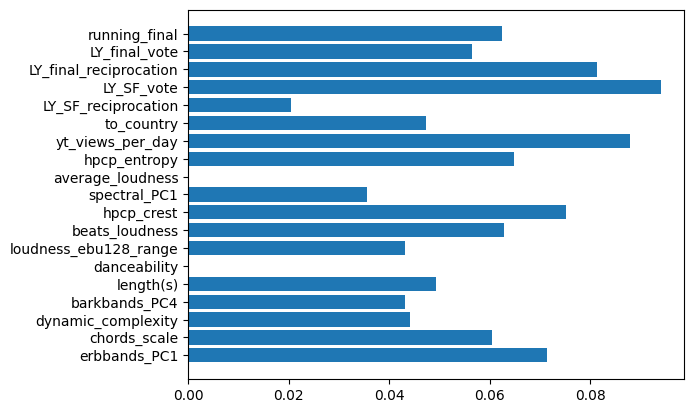

In [ ]:
def get_sorted_feature_importances(X_train_df, automl):

    # Get feature importances from the XGBoost model
    feature_importances = automl.model.estimator.feature_importances_

    # Create a DataFrame with feature names and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': X_train_df.columns,
        'Importance': feature_importances
    })

    # Sort by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

    print("Sorted Feature Importances:")
    print(feature_importance_df)

    return feature_importance_df

sorted_features = get_sorted_feature_importances(X_train_df, automl)

# plot feature importance
import matplotlib.pyplot as plt
#plt.barh(automl.feature_names_in_, automl.feature_importances_)
#plt.figure(figsize=(20, 15))
plt.barh(X_train_df.columns, automl.model.estimator.feature_importances_)
sorted_features

In [ ]:
# pickle and save the automl object
import pickle
with open('model-name.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

Test Data Evaluation

In [ ]:
# compute predictions of testing dataset
y_pred = automl.predict(X_test)
# compute different metric values on testing dataset
from flaml.ml import sklearn_metric_loss_score
print('r2', '=', round(1 - sklearn_metric_loss_score('r2', y_pred, y_test), 2))
print('mse', '=', round(sklearn_metric_loss_score('mse', y_pred, y_test), 2))
print('mae', '=', round(sklearn_metric_loss_score('mae', y_pred, y_test), 2))

r2 = 0.21
mse = 0.07
mae = 0.22


Train Data Evaluation

In [ ]:
# compute predictions of testing dataset
y_pred = automl.predict(X_train)
# compute different metric values on testing dataset
from flaml.ml import sklearn_metric_loss_score
print('r2', '=', round(1 - sklearn_metric_loss_score('r2', y_pred, y_train), 2))
print('mse', '=', round(sklearn_metric_loss_score('mse', y_pred, y_train), 2))
print('mae', '=', round(sklearn_metric_loss_score('mae', y_pred, y_train), 2))

r2 = 0.48
mse = 0.05
mae = 0.18


## 6. Evaluation

Prediction are evaluated with R2, Average Rank Error, Spearman rank correlation coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, roc_auc_score


def evaluate_model(model, X_train, y_train, X_val1, y_val1, classification=False, y_val1_class=None):

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val1_pred = model.predict(X_val1)

    # Evaluate regression metrics
    def evaluate_regression(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return {"MAE": round(mae, 2), "MSE": round(mse, 2),"RMSE": round(rmse, 2),"R2": round(r2, 2)}

    train_metrics = evaluate_regression(y_train, y_train_pred)
    val1_metrics = evaluate_regression(y_val1, y_val1_pred)

    print("Training Performance:", train_metrics)
    print("Validation 1 Performance:", val1_metrics)

    # Plot results
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, color='blue')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', linewidth=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Training Set")

    plt.subplot(1, 2, 2)
    plt.scatter(y_val1, y_val1_pred, color='green')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', linewidth=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Validation 1 Set")

    plt.tight_layout()
    plt.show()

    if classification:
     # Determine the thresholds
      threshold1 = np.sort(y_val1_pred)[9]

      # Label top 10 predictions as positive class
      y_val1_pred_class = np.where(y_val1_pred <= threshold1, 1, 0)

      df_val = test_data[['performer', 'song', 'to_country', 'place_contest']].reset_index(drop=True)

      df_val['Prediction'] = y_val1_pred
      df_val['Prediction-Class'] = y_val1_pred_class
      df_val['Ground-Truth'] = y_val1_class.values

      # Add "predicted_position" column based on sorted "Prediction"
      df_val = df_val.sort_values("Prediction").reset_index(drop=True)
      df_val['predicted_position'] = df_val.index + 1

      # Calculate rank similarity metrics
      from scipy.stats import spearmanr, kendalltau

    # Spearman rank correlation
      spearman_corr, spearman_pvalue = spearmanr(df_val['place_contest'], df_val['predicted_position'])

    # Kendall rank correlation
      kendall_corr, kendall_pvalue = kendalltau(df_val['place_contest'], df_val['predicted_position'])

    # Average rank error
      rank_errors = abs(df_val['place_contest'] - df_val['predicted_position'])
      average_rank_error = rank_errors.mean()

    # Evaluate regression metrics
      train_r2 = r2_score(y_train, y_train_pred)
      test_r2 = r2_score(y_val1, y_val1_pred)

    # Save metrics to a DataFrame
      metrics_df = pd.DataFrame({
          "Train R2": [round(train_r2, 2)],
          "Test R2": [round(test_r2, 2)],
          "Spearman Coefficient": [round(spearman_corr, 2)],
          "Spearman P-Value": [round(spearman_pvalue, 2)],
          "Kendall Coefficient": [round(kendall_corr, 2)],
          "Kendall P-Value": [round(kendall_pvalue, 2)],
          "Average Rank Error": [round(average_rank_error, 2)]
      })

    # Print metrics DataFrame
      print("\nMetrics:")
      print(metrics_df)

      print("\nValidation 1 Classification Report")
      print(classification_report(y_val1_class, y_val1_pred_class))
      print("Confusion Matrix:\n", confusion_matrix(y_val1_class, y_val1_pred_class))
      print("ROC AUC:", roc_auc_score(y_val1_class, y_val1_pred_class))

      print("\nRank Similarity Metrics:")
      print(f"Spearman Rank Correlation: {spearman_corr:.2f} (p-value: {spearman_pvalue:.2f})")
      print(f"Kendall Rank Correlation: {kendall_corr:.2f} (p-value: {kendall_pvalue:.2f})")
      print(f"Average Rank Error: {average_rank_error:.2f}")

      return df_val, metrics_df


Training Performance: {'MAE': 0.18, 'MSE': 0.05, 'RMSE': 0.22, 'R2': 0.48}
Validation 1 Performance: {'MAE': 0.22, 'MSE': 0.07, 'RMSE': 0.27, 'R2': 0.21}


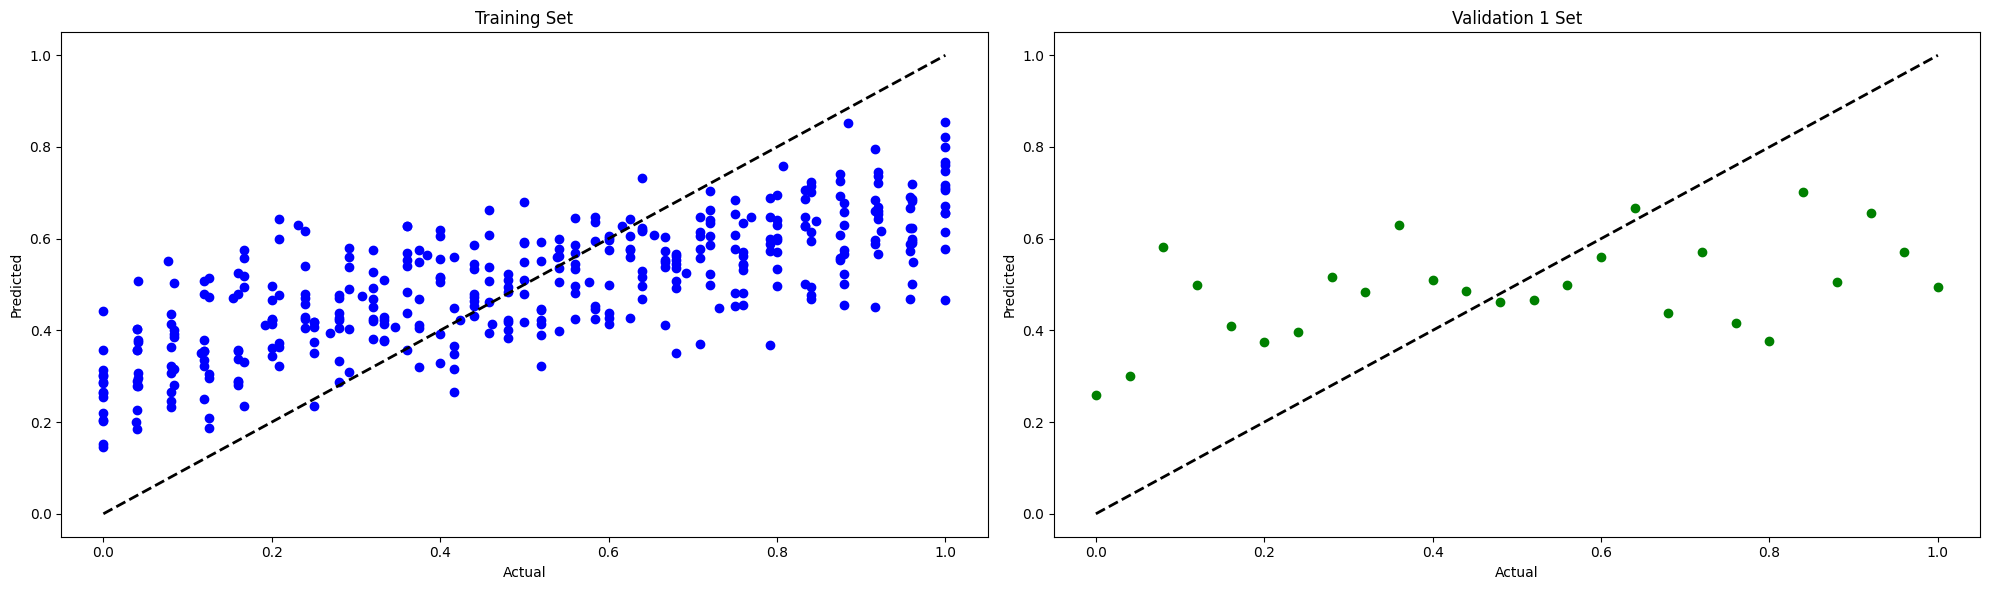


Metrics:
   Train R2  Test R2  Spearman Coefficient  Spearman P-Value  \
0      0.48     0.21                  0.42              0.03   

   Kendall Coefficient  Kendall P-Value  Average Rank Error  
0                 0.29             0.04                5.92  

Validation 1 Classification Report
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        16
           1       0.50      0.50      0.50        10

    accuracy                           0.62        26
   macro avg       0.59      0.59      0.59        26
weighted avg       0.62      0.62      0.62        26

Confusion Matrix:
 [[11  5]
 [ 5  5]]
ROC AUC: 0.59375

Rank Similarity Metrics:
Spearman Rank Correlation: 0.42 (p-value: 0.03)
Kendall Rank Correlation: 0.29 (p-value: 0.04)
Average Rank Error: 5.92


(                     performer                         song  to_country  \
 0               Netta Barzilai                          Toy          22   
 1               Eleni Foureira                        Fuego          10   
 2                Mikolas Josef                    Lie To Me          11   
 3                          AWS                 Viszlát Nyár          19   
 4            Benjamin Ingrosso                Dance You Off          41   
 5   Ermal Meta & Fabrizio Moro    Non Mi Avete Fatto Niente          23   
 6               Jessica Mauboy                  We Got Love           2   
 7                       Waylon                Outlaw In 'Em          30   
 8              Madame Monsieur                        Mercy          15   
 9                      Equinox                        Bones           8   
 10                   Rasmussen                Higher Ground          12   
 11          Ieva Zasimauskaitė               When We're Old          25   
 12         

In [ ]:
evaluate_model(automl, X_train, y_train, X_test, y_test, classification=True, y_val1_class=y_class10test)
